## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
from planning import a_star
from planning import heuristic_euclidean, heuristic_manhattan

%matplotlib inline

#from bresenham import bresenham

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Found a path.
Found a path.


In [2]:
plt.rcParams['figure.figsize'] = 12, 12

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [3]:
?create_grid

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [8]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [15]:
# Static drone altitude (meters)
drone_altitude = 25

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [16]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid = create_grid(data, drone_altitude, safe_distance)

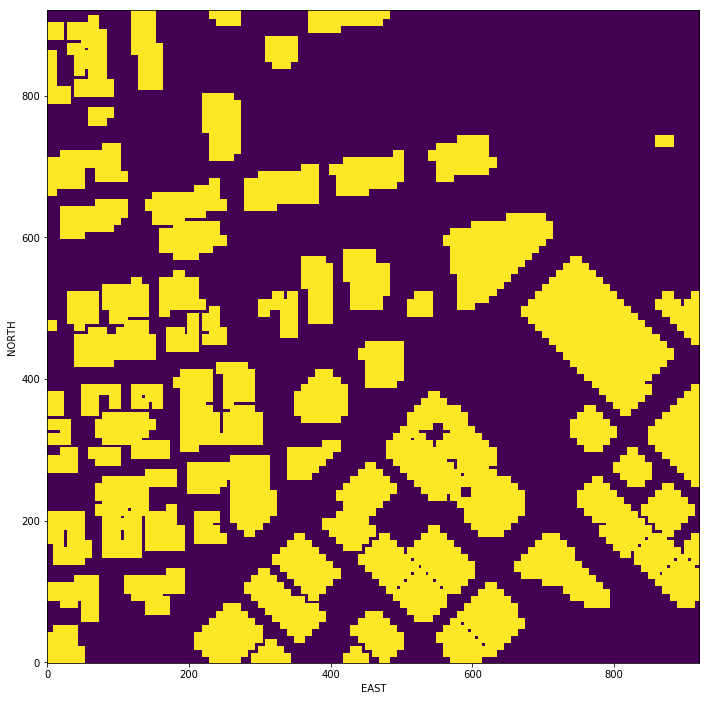

In [17]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [ ]:
def breadth_first(grid, start, goal):
    q = Queue()
    q.put((0, start))
    visited = set(start)
    branch = {}
    found = False
    mapa = np.zeros(np.shape(grid))
    mapa[mapa > -1] = inf 

    while not q.empty(): 
        item = q.get()
        current_node = item[1]
        
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
        
        if current_node == goal: 
            print('Found a path.')
            found = True
            break
        else:
            valid = valid_actions(grid, current_node)
            for action in valid:
                da = action.value
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                branch_cost = action.cost + current_cost
                mapa[current_node] = current_cost
                if next_node not in visited:
                    visited.add(next_node)
                    q.put((branch_cost, next_node))    
                    branch[next_node] = (branch_cost, current_node, action)
   
    print(current_cost)
    return mapa

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [9]:
start_ne = (25,  100)
goal_ne = (750., 370.)

Compute the lowest cost path with `a_star`. 

In [10]:
# TODO: use `a_star` to compute the lowest cost path
path_euc, cost_euc, steps_euc = a_star(grid, heuristic_euclidean, start_ne, goal_ne)
path_man, cost_man, steps_man = a_star(grid, heuristic_manhattan, start_ne, goal_ne)

print(len(path_euc), cost_euc, len(path_man), cost_man)

Found a path.
Found a path.
756 866.5950211536186 766 912.2173875177057


Let's plot the path!

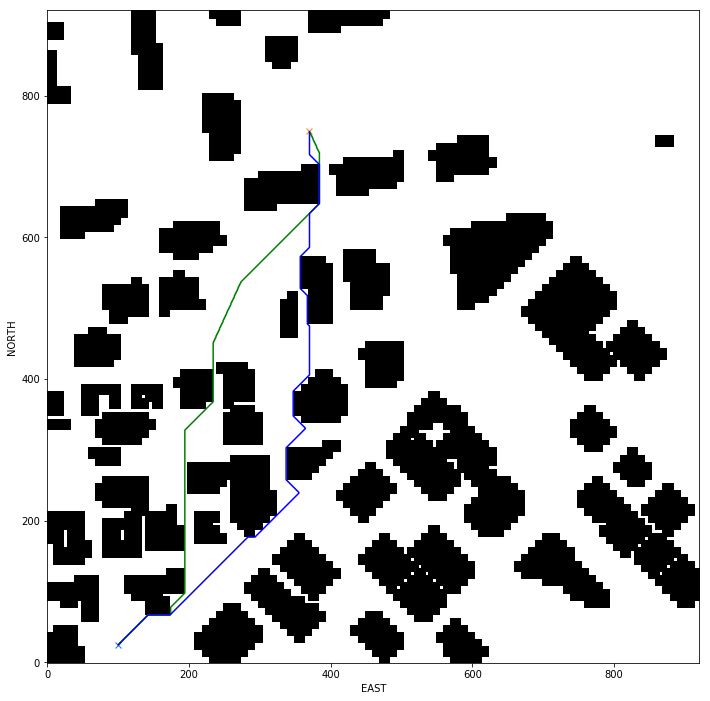

In [11]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp_euc = np.array(path_euc)
plt.plot(pp_euc[:, 1], pp_euc[:, 0], 'g')

pp_man = np.array(path_man)
plt.plot(pp_man[:, 1], pp_man[:, 0], 'b')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [12]:
def point(p):
    #reshape (1,-1), -1 é um valor não especificado, mas é esperado que seja 3
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [13]:
def prune_path_colin(path):

    pruned_path = [p for p in path]
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        if collinearity_check(p1, p2, p3):
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
            
    return pruned_path

In [19]:
from bresenham import bresenham

def prune_path_bres(path, gridd, goal):
    
    pruned_path = [p for p in path]
    i = 0
    
    while i < len(pruned_path) - 2:
        p1 = pruned_path[i]
        p2 = pruned_path[i+2]
        k = 0
        
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        #print(cells)
        
        for c in cells:
            k += gridd[c]
            #print(k)
            
        if k > 0:
            i += 1
        else:
            pruned_path.remove(pruned_path[i+1])
        
    pruned_path.append(goal)
    
    return pruned_path          
        

Prune the path.

In [20]:
pruned_path_colin = prune_path_colin(path_euc)
print(len(pruned_path_colin))

p_p_bres = prune_path_bres(path_euc, grid, goal_ne)
print(len(p_p_bres))


116
10


In [21]:
#pruned_path_colin

Replot the path, it will be the same as before but the drone flight will be much smoother.

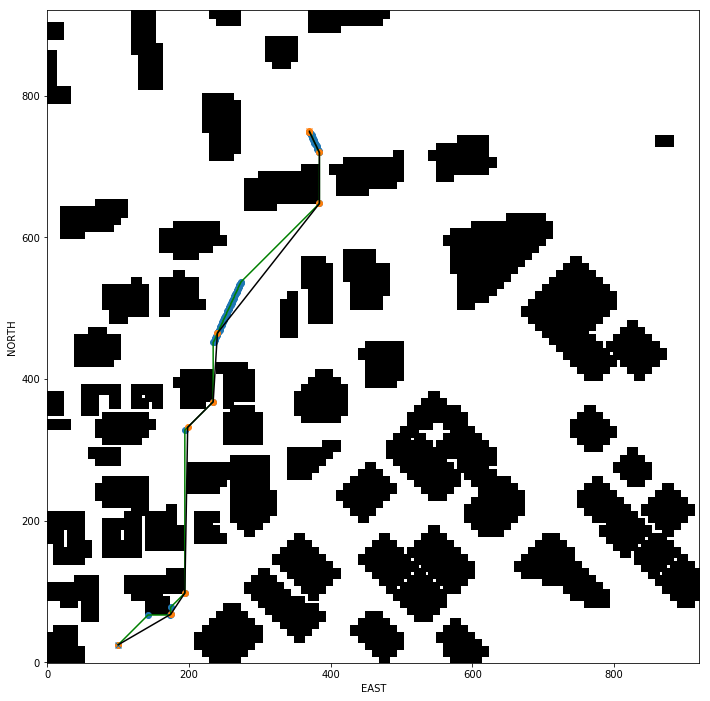

In [22]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(pruned_path_colin)
plt.plot(pp[:, 1], pp[:, 0], 'g')
plt.scatter(pp[:, 1], pp[:, 0])

pp = np.array(p_p_bres)
plt.plot(pp[:, 1], pp[:, 0], 'k')
plt.scatter(pp[:, 1], pp[:, 0])


plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!

[solution](/notebooks/A-Star-City-Solution.ipynb)